In [1]:
debug = False

In [2]:
from __future__ import division
import numpy as np
import math
import copy
import time
import sys
import os
import imp

from toricgame import *
import toric_lattice
import perfect_matching

home = os.environ['HOME']

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def run2D(size=4,p=0.1):

   L=toric_lattice.PlanarLattice(size)

   L.applyRandomErrors(p,0)
    
   #print(L.array)
   L.measureStars()
   L.measurePlaquettes()
    
   L.findAnyons()
   #print("Syndrome positions")
   #L.positions_anyons_P = np.array(L.positions_anyons_P)
   #print(L.positions_anyons_P)

   matchingX = perfect_matching.match_toric_2D(size,L.positions_anyons_P)
   #matchingZ=perfect_matching.match_toric_2D(size,L.positions_anyons_S)

   if debug:
      print(matchingX)

   L.apply_matching("X",matchingX)
   #L.apply_matching("Z",matchingZ)

   error = L.measure_logical()
   return ((error[0][0] == -1) or (error[0][1] == -1))


def makePathBetweenAnyons(size, matching):
    flips=[]
    for pair in matching:
        
        pair.sort(key=lambda x: (x[0], x[1]))

        [p0,p1]=pair[0]
        [q0,q1]=pair[1]

        m=2*size

        d0=(q0-p0)%m
        d1=(q1-p1)%m
        
        if d0 < m-d0:
            end0=q0
            for x in range(1,d0,2):
                flips+=[[(p0+x)%m,p1]]
        else:
            end0=p0
            for x in range(1,m-d0,2):
                flips+=[[(q0+x)%m,q1]]

        if d1 < m-d1:
            for y in range(1,d1,2):
                flips+=[[end0,(p1+y)%m]]
        else:
            for y in range(1,m-d1,2):
                flips+=[[end0,(q1+y)%m]]
                
    return flips

def run2DwithEnvironment(size=4,p=0.1):

   tgame = ToricGameEnv()
   tgame.init(size)
   state = tgame.reset(p)

   #print([tgame.state.action_to_coord(a) for a in tgame.initialmoves])
    
   #print("Syndrome positions Env")
   #tgame.state.syndrome_pos = np.sort(tgame.state.syndrome_pos, axis=0)
   
   #tgame.state.syndrome_pos.sort(key=lambda x: (x[0], x[1]))
   #print(tgame.state.syndrome_pos)

   
   matchingX = perfect_matching.match_toric_2D(size, tgame.state.syndrome_pos )

   if debug:
      print(matchingX)
   flips = makePathBetweenAnyons(size, matchingX)

   #print(flips)
   
   if len(flips) == 0:
        error = -1 if tgame.state.has_logical_error(tgame.initialmoves) else 1
        
   for flip in flips:
   #     print("Flippping pair ", flip)
        laststate, error, _, _ = tgame.step(flip)

   #print(flips, error)
   return True if error == -1 else False

In [9]:
debug=False
np.random.seed(12345+22)
print(run2D(3,0.14))
np.random.seed(12345+22)
print(run2DwithEnvironment(3,0.14))

True
True


In [10]:
def getStatistics(d, env = False, numGames = 10000):
    np.random.seed(12345)

    curve = []
    pXs = np.arange(0.01, 0.15, 0.01)
    for p in pXs:

        res = 0
        for i in range(numGames):
            error = False
            if not env:
                error = run2D(d,p)
            else:
                error = run2DwithEnvironment(d,p)
                
            if error:
                continue

            res += 1.0

        curve.append( res/numGames )
        
    return pXs, curve

In [14]:
pXs, d3mwpmcurve = getStatistics(3, False, 10000)
pXs, d3envcurve = getStatistics(3, True, 10000)
pXs, d5mwpmcurve = getStatistics(5, False, 10000)
pXs, d5envcurve = getStatistics(5, True, 10000)

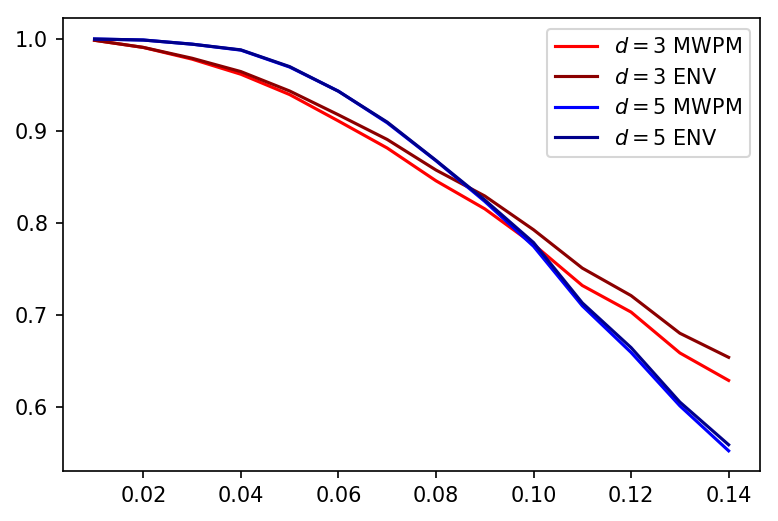

In [15]:
# w/o sorting
#d3curve = np.loadtxt("mwpm-d3-50000games.txt")
#d5curve = np.loadtxt("mwpm-d5-10000games.txt")

fig, ax = plt.subplots(dpi=150)
ax.plot(pXs, d3mwpmcurve, c='red', label='$d=3$ MWPM')
ax.plot(pXs, d3envcurve, c='darkred', label='$d=3$ ENV')
ax.plot(pXs, d5mwpmcurve, c='blue', label='$d=5$ MWPM')
ax.plot(pXs, d5envcurve, c='darkblue', label='$d=5$ ENV')
ax.legend(fancybox=True)

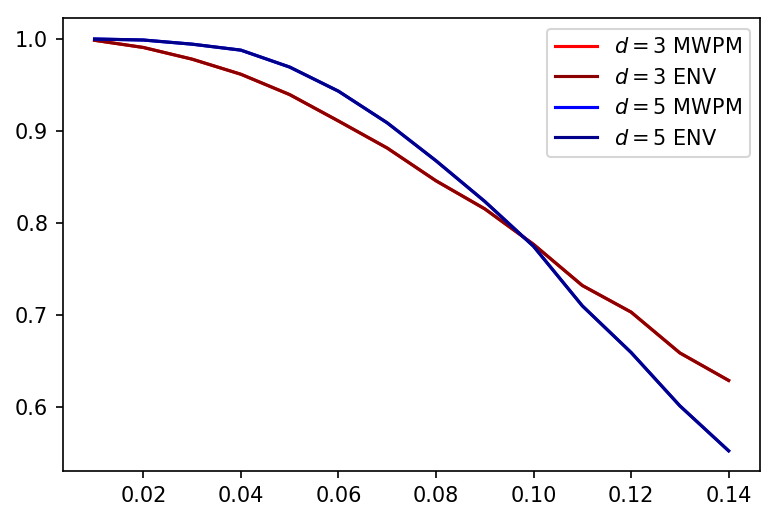

In [100]:
#d3curve = np.loadtxt("mwpm-d3-50000games.txt")
#d5curve = np.loadtxt("mwpm-d5-10000games.txt")

fig, ax = plt.subplots(dpi=150)
ax.plot(pXs, d3mwpmcurve, c='red', label='$d=3$ MWPM')
ax.plot(pXs, d3envcurve, c='darkred', label='$d=3$ ENV')
ax.plot(pXs, d5mwpmcurve, c='blue', label='$d=5$ MWPM')
ax.plot(pXs, d5envcurve, c='darkblue', label='$d=5$ ENV')
ax.legend(fancybox=True)

In [142]:
def findMismatch():

    curve = []
    p = 0.14
    d = 3
    
    for game in range(1000):
        
        np.random.seed(12345+game)
        error1 = run2D(d,p)
        np.random.seed(12345+game)
        error2 = run2DwithEnvironment(d,p)

        if error1 != error2:
            print(game)
            print(error1, error2)

In [148]:
findMismatch()

22
(True, False)
68
(True, False)
88
(True, False)
116
(True, False)
152
(True, False)
181
(True, False)
184
(True, False)
230
(True, False)
259
(True, False)
288
(True, False)
297
(True, False)
368
(True, False)
424
(True, False)
432
(True, False)
433
(True, False)
434
(True, False)
465
(True, False)
475
(True, False)
513
(True, False)
520
(True, False)
573
(True, False)
589
(True, False)
597
(True, False)
670
(True, False)
699
(True, False)
728
(False, True)
757
(True, False)
855
(True, False)
867
(True, False)
897
(True, False)
907
(True, False)
926
(True, False)
984
(False, True)
987
(True, False)


In [91]:
np.random.seed(12345+710)
print(run2D(3,0.14))
np.random.seed(12345+710)
print(run2DwithEnvironment(3,0.14))

[]
[]
[[-1, 1], [1, 1]]
True
[]
[]
([], -1)
True
